需要文件

* egypt_retweets.net
* 9_11_edgelist.txt
* 9_11_attrib.txt
* triadic.py(修改)
* draw_triads.py(修改)
* hc.py(修改)
* hiclus_blockmodel(修改)
* campaign_short.csv

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict
import csv
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering

# 脚本
import triadic
import draw_triads  
import hc 
import hiclus_blockmodel

# Chapter 4
<font color=orange>**埃及革命推特转发网络**</font>

In [2]:
e = nx.read_pajek("egypt_retweets.net")

In [3]:
len(e)

25178

##### 组元、子图、岛屿方法

In [4]:
components = sorted(list(nx.connected_components(e)), key=len, reverse=True)    # 各个组元的节点集
len(components)

3122

In [5]:
cc = e.subgraph(components[0])    # 最大的组元，含17762个节点;使之成为子图而非仅仅是节点集
len(cc)

17762

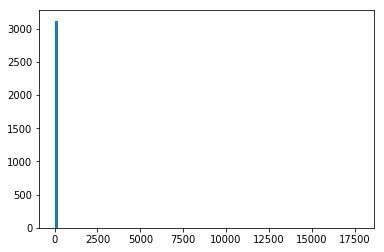

In [6]:
# 各组元节点数直方图
component_node_nums = [len(c) for c in nx.connected_components(e)]   # 各组元节点数直方图
plt.hist(component_node_nums, bins=100);

In [7]:
# 有一个节点为17762的超大组元，2429个（最多）双节点组元
counter = pd.Series(component_node_nums).value_counts().sort_index(ascending=False).to_frame(name="组元数")
counter.index.name = "组元节点数"
counter

,组元数
组元节点数,
17762,1
64,1
16,2
14,1
13,1
11,2
10,5
9,11
8,7


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


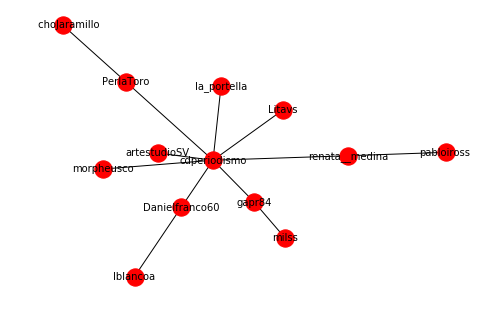

In [8]:
# 找出只有13个节点的唯一组元
for comp in components:
    if len(comp) == 13:
        comp13 = e.subgraph(comp)

nx.draw(comp13, with_labels=True, font_size=10)

In [9]:
# 网络中边数据字典weight作为键
# 删去weight值小于等于给定值的边
def trim_edges(g, threshold):
    ng = nx.Graph()
    for from_, to, edata in g.edges(data=True):
        weight = edata['weight']
        if weight > threshold:
            ng.add_edge(from_, to, weight=weight)
    return ng


SubGraph = namedtuple("SubGraph", "level graph")

def island_method(g, iteration):
    # 利用“一系列水平面”对原图进行“加工”，得到与之对应的一系列处理后的图
    min_weight = int(min(edata['weight'] for from_, to, edata in g.edges(data=True)))
    max_weight = int(max(edata['weight'] for from_, to, edata in g.edges(data=True)))
    step = int((max_weight - min_weight) / iteration)
    return [SubGraph(level, trim_edges(g, level)) for level in range(min_weight, max_weight, step)]

In [10]:
# 对原图e最大的组元cc进行island method分析
data = island_method(cc, iteration=5)
info = [[res.level, len(res.graph), len(list(nx.connected_components(res.graph)))] for res in data]
info = pd.DataFrame(info, columns=["海平面阈值", "子图节点", "子图所含组元数"] , index=['island-' + str(i) for i in range(1,6)])
info

,海平面阈值,子图节点,子图所含组元数
island-1,1,12360,314
island-2,62,27,11
island-3,123,8,3
island-4,184,5,2
island-5,245,5,2


##### 个人中心网

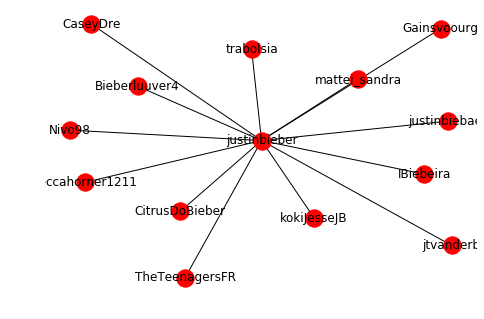

In [11]:
# Justinbieber的个人中心网
nx.draw(nx.ego_graph(e, 'justinbieber'), with_labels=True)

In [12]:
# 个人中心网：搜索深度2
# 多图转换为简单图，图的分类参见 https://www.cnblogs.com/minglex/p/9205160.html
bieb = nx.Graph(nx.ego_graph(e, 'justinbieber', radius=2))
len(bieb)

22

In [13]:
nx.average_clustering(bieb)      # 聚类系数

0.12727272727272726

In [14]:
ghonim = nx.Graph(nx.ego_graph(cc, 'Ghonim', radius=2))
len(ghonim)

3450

In [15]:
nx.average_clustering(ghonim)

0.04332254475699302

##### 16个有向三元组——三元组普查

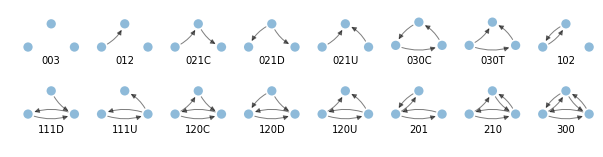

In [16]:
t = triadic.triad_graphs()
n = len(t)
pos = {'a':(0,0),'b':(1,1),'c':(2,0)}
fig = plt.figure(figsize=(8,2))
fig.subplots_adjust(left=0,right=1,top=1.0)

for i, (name, graph) in enumerate(sorted(t.items())):
    ax = plt.subplot(2,n/2,i+1)
    draw_triads.draw(graph, pos, ax, name)

In [17]:
# Example1 : 风筝网络图
g = nx.DiGraph(nx.krackhardt_kite_graph())
nx.triadic_census(g)                   # 库内置函数

{'003': 22,
 '012': 0,
 '102': 63,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 24,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 11}

In [18]:
# 来自GitHub，微修改
g = nx.DiGraph(nx.krackhardt_kite_graph())
census, node_census = triadic.triadic_census(g)
census

{'003': 22,
 '012': 0,
 '102': 63,
 '021D': 0,
 '021U': 0,
 '021C': 0,
 '111D': 0,
 '111U': 0,
 '030T': 0,
 '030C': 0,
 '201': 24,
 '120D': 0,
 '120U': 0,
 '120C': 0,
 '210': 0,
 '300': 11}

In [19]:
node_census

{0: {'003': 0,
  '012': 0,
  '102': 14,
  '021D': 0,
  '021U': 0,
  '021C': 0,
  '111D': 0,
  '111U': 0,
  '030T': 0,
  '030C': 0,
  '201': 8,
  '120D': 0,
  '120U': 0,
  '120C': 0,
  '210': 0,
  '300': 4},
 1: {'003': 0,
  '012': 0,
  '102': 11,
  '021D': 0,
  '021U': 0,
  '021C': 0,
  '111D': 0,
  '111U': 0,
  '030T': 0,
  '030C': 0,
  '201': 4,
  '120D': 0,
  '120U': 0,
  '120C': 0,
  '210': 0,
  '300': 3},
 2: {'003': 0,
  '012': 0,
  '102': 7,
  '021D': 0,
  '021U': 0,
  '021C': 0,
  '111D': 0,
  '111U': 0,
  '030T': 0,
  '030C': 0,
  '201': 4,
  '120D': 0,
  '120U': 0,
  '120C': 0,
  '210': 0,
  '300': 1},
 3: {'003': 0,
  '012': 0,
  '102': 7,
  '021D': 0,
  '021U': 0,
  '021C': 0,
  '111D': 0,
  '111U': 0,
  '030T': 0,
  '030C': 0,
  '201': 3,
  '120D': 0,
  '120U': 0,
  '120C': 0,
  '210': 0,
  '300': 2},
 4: {'003': 0,
  '012': 0,
  '102': 4,
  '021D': 0,
  '021U': 0,
  '021C': 0,
  '111D': 0,
  '111U': 0,
  '030T': 0,
  '030C': 0,
  '201': 2,
  '120D': 0,
  '120U': 0,
  '120

In [20]:
# 各节点的三元组普查
keys = list(census.keys())
data = pd.DataFrame(node_census)
data.T

,003,012,021C,021D,021U,030C,030T,102,111D,111U,120C,120D,120U,201,210,300
0,0,0,0,0,0,0,0,14,0,0,0,0,0,8,0,4
1,0,0,0,0,0,0,0,11,0,0,0,0,0,4,0,3
2,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,1
3,0,0,0,0,0,0,0,7,0,0,0,0,0,3,0,2
4,0,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0
5,0,0,0,0,0,0,0,5,0,0,0,0,0,1,0,1
6,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,5,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<font color=orange>**恐怖袭击网络**</font>

In [21]:
# Example 2
g = nx.Graph()
with open('9_11_edgelist.txt', 'r') as in_file:
    rf = csv.reader(in_file, delimiter=',')
    for line in rf:     # line :  from  to  强度  confirm        
        g.add_edge(line[0], line[1], weight=line[2], conf=line[3])

# 读入19个劫机者的航班信息，作为节点的属性（字典形式）
with open('9_11_attrib.txt', 'r') as in_file:
    rf = csv.reader(in_file, delimiter=',')
    for line in rf:    # line: name  航班号
        g.node[line[0]]['flight'] = line[1]

cc = g.subgraph(max(nx.connected_components(g), key=len))   # 恐怖袭击最大组元


# 节点三元组普查 ‘300’类型数量降序排列
_, node_census = triadic.triadic_census(cc)
type300 = sorted([(node, cs['300']) for node, cs in node_census.items()], key=itemgetter(1), reverse=True)
type300                 # 穆罕默德·阿塔驾着飞机撞在了世贸中心的北楼上

[('Mohamed Atta', 33),
 ('Hani Hanjour', 23),
 ('Marwan Al-Shehhi', 19),
 ('Abdul Aziz Al-Omari', 10),
 ('Nawaf Alhazmi', 7),
 ('Essid Sami Ben Khemais', 6),
 ('Zacarias Moussaoui', 5),
 ('Ziad Jarrah', 4),
 ('Waleed Alshehri', 4),
 ('Majed Moqed', 3),
 ('Lotfi Raissi', 3),
 ('Salem Alhazmi', 3),
 ('Djamal Beghal', 3),
 ('Hamza Alghamdi', 2),
 ('Said Bahaji', 2),
 ('Khalid Al-Mihdhar', 1),
 ('Saeed Alghamdi', 1),
 ('Ramzi Bin al-Shibh', 1),
 ('Wail Alshehri', 1),
 ('Satam Suqami', 1),
 ('Tarek Maaroufi', 1),
 ('Bandar Alhazmi', 0),
 ('Rayed Mohammed Abdullah', 0),
 ('Ahmed Alnami', 0),
 ('Abdussattar Shaikh', 0),
 ('Osama Awadallah', 0),
 ('Zakariya Essabar', 0),
 ('Fayez Ahmed', 0),
 ('Mohand Alshehri', 0),
 ('Mustafa Ahmed al-Hisawi', 0),
 ('Ahmed Alghamdi', 0),
 ('Ahmed Al Haznawi', 0),
 ('Jerome Courtaillier', 0),
 ('David Courtaillier', 0),
 ('Ahmed Ressam', 0),
 ('Kamel Daoudi', 0),
 ('Faisal Al Salmi', 0),
 ('Mohamed Abdi', 0),
 ('Mamoun Darkazanli', 0),
 ('Ahmed Khalil Ibrahim 

<font color=orange>**高加索地区经济网络**</font>

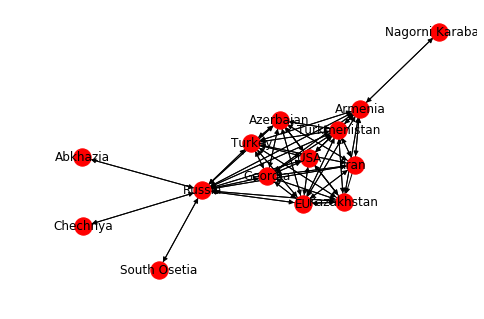

In [22]:
eco = nx.read_pajek("economic.net")
nx.draw(eco, with_labels=True)

##### 检测派系（最大完备子图）

In [23]:
e2 = trim_edges(eco, 0.5)       # 删去权重<0.5的边
cliques = nx.find_cliques(e2)
for clique in cliques:
    print(clique)

['Nagorni Karabakh', 'Armenia']
['South Osetia', 'Russia']
['Abkhazia', 'Russia']
['EU', 'Russia', 'Kazakhstan']
['EU', 'Russia', 'Turkey']
['EU', 'Georgia']
['EU', 'USA', 'Kazakhstan']
['EU', 'USA', 'Turkey']
['EU', 'Azerbajan']
['EU', 'Armenia']
['Chechnya', 'Russia']


##### 层次聚类 与 块模型

In [24]:
country_abbr = {
    'Abkhazia': 'AB',
    'Armenia': 'AR',
    'Azerbajan': 'AZ',
    'Chechnya': 'CH',
    'EU': 'EU',
    'Georgia': 'GE',
    'Iran': 'IR',
    'Kazakhstan': 'KZ',
    'Nagorni Karabakh': 'NK',
    'Russia': 'RU',
    'South Osetia': 'SO',
    'Turkey': 'TK',
    'Turkmenistan': 'TR',
    'USA': 'US'
}


dist_matrix = pd.DataFrame(dict(nx.all_pairs_shortest_path_length(eco)))  # 非对称！！！
dist_matrix.rename(columns=country_abbr, inplace=True)
dist_matrix.rename(index=country_abbr, inplace=True)
dist_matrix           # 距离矩阵，非对称！！！

,AB,AR,AZ,CH,EU,GE,IR,KZ,NK,RU,SO,TK,TR,US
AB,0,2,2,2,2,2,2,2,3,1,2,2,2,2
AR,2,0,2,2,1,1,1,1,1,1,2,1,1,1
AZ,2,2,0,2,1,1,1,1,3,1,2,1,1,1
CH,2,2,2,0,2,2,2,2,3,1,2,2,2,2
EU,2,1,1,2,0,1,1,1,2,1,2,1,1,1
GE,2,1,1,2,1,0,1,1,2,1,2,1,1,1
IR,2,1,1,2,1,1,0,2,2,1,2,1,1,2
KZ,2,1,1,2,1,1,1,0,2,1,2,1,1,1
NK,3,1,3,3,2,2,2,2,0,2,3,2,2,2
RU,1,1,1,1,1,1,1,1,2,0,1,1,1,1


* 使用hc.py脚本 聚类（基于Scipy）
* 使用hiclus_blockmodel.py脚本 块模型可视化

In [25]:
# 聚类组
clusters = hc.create_hc(eco)
clusters

[['Abkhazia', 'Chechnya', 'South Osetia'],
 ['Armenia', 'EU', 'Georgia', 'Kazakhstan', 'Turkey', 'Turkmenistan', 'USA'],
 ['Azerbajan', 'Iran', 'Russia'],
 ['Nagorni Karabakh']]

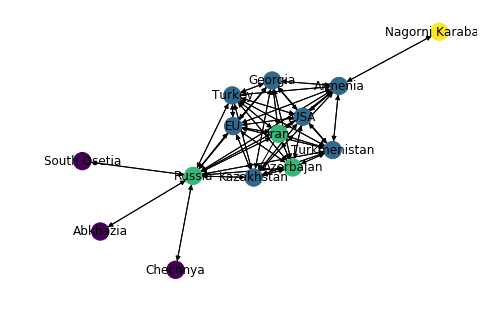

In [26]:
assign_map = {}
for i, cluster in enumerate(clusters):
    for node in cluster:
        assign_map[node] = i + 1

assignment = [assign_map[node] for node in eco.nodes()]    # 聚类标签
nx.draw(eco, node_color=assignment, with_labels=True)      # 根据聚类标签可视化

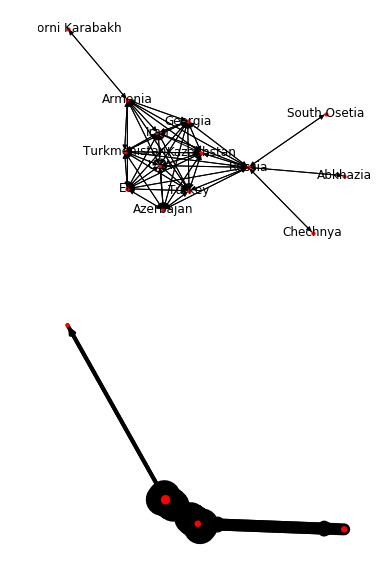

In [27]:
# 块模型可视化
hiclus_blockmodel.hiclus_blockmodel(nx.DiGraph(eco))

* 使用sklearn中的凝聚聚类算法

In [28]:
# 凝聚聚类，设定聚为5类，距离直接给出，complete连接； 聚类标签
assignment = AgglomerativeClustering(n_clusters=5, affinity="precomputed", linkage='complete').fit_predict(dist_matrix)
assignment

array([0, 1, 2, 0, 1, 2, 1, 2, 4, 0, 3, 1, 2, 2], dtype=int64)

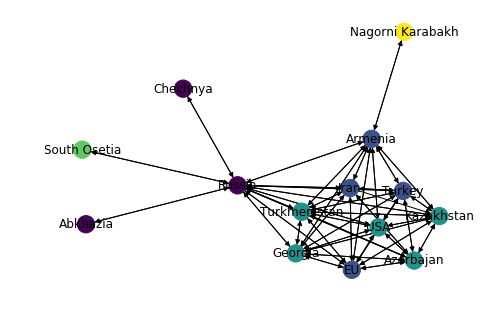

In [29]:
nx.draw(eco, node_color=assignment, with_labels=True)     # 根据聚类标签聚类可视化

In [30]:
# 聚类组
partition = defaultdict(list)
for label, node in zip(assignment, eco.nodes()):
    partition[label].append(node)
clusters = list(partition.values())
clusters

[['Abkhazia', 'Chechnya', 'Russia'],
 ['Armenia', 'EU', 'Iran', 'Turkey'],
 ['Azerbajan', 'Georgia', 'Kazakhstan', 'Turkmenistan', 'USA'],
 ['Nagorni Karabakh'],
 ['South Osetia']]

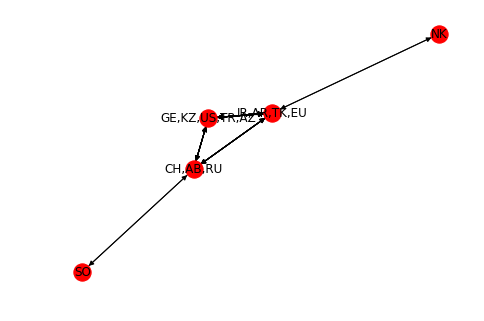

In [31]:
# 块模型可视化
blocks = nx.quotient_graph(eco, clusters)
labels = {cluster: ','.join([country_abbr[country] for country in cluster]) for cluster in blocks.nodes()}
nx.draw(blocks, labels=labels, with_labels=True)

# Chapter 5

<font color=orange>**政治选举**</font>

In [32]:
data = pd.read_csv("campaign_short.csv", 
                   names=["Source ID", "Tax ID", "Org.Type", "Month", "Day", "Cent.", "Yr", "Amount", "Other ID", "Candidate ID", "Trans.ID"],
                   usecols=[0] + list(range(4, 14)))
data.head(20)

,Source ID,Tax ID,Org.Type,Month,Day,Cent.,Yr,Amount,Other ID,Candidate ID,Trans.ID
0,C00000042,99034551644,24K,2,8,19,99,1000,C00319285,S4MO00037,175211
1,C00000042,99034551644,24K,5,20,19,99,1250,C00208090,H6IL14095,175212
2,C00000042,99034551644,24K,5,20,19,99,1000,C00013573,H6IL06026,175213
3,C00000042,99034551644,24K,5,20,19,99,1000,C00079020,H8IL10016,175214
4,C00000042,20035433084,24K,3,28,20,0,2500,C00350785,H0IL10120,946633
5,C00000042,20035433084,24K,2,15,20,0,1000,C00350785,H0IL10120,946634
6,C00000042,20035433084,24K,3,28,20,0,1000,C00346759,H8CT05104,946635
7,C00000042,20035433084,24K,3,13,20,0,500,C00257121,H2IL01042,946636
8,C00000042,20035433084,24K,2,17,20,0,500,C00350496,H0IL15061,946637
9,C00000042,20035834069,24K,6,5,20,0,1000,C00303354,S4MI00165,1258632


In [33]:
# 构建二模图（不同身份的节点）
g = nx.Graph()
pacs = []           # 行动委员会
candidates = []     # 候选人

for idx, row in data.iterrows():
    p = row.loc['Source ID']
    c = row.loc['Candidate ID']
    cash = int(row.loc['Amount'])
    if p not in pacs:
        pacs.append(p)
    if c not in candidates:
        candidates.append(c)
    g.add_edge(p, c, weight=cash)

D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


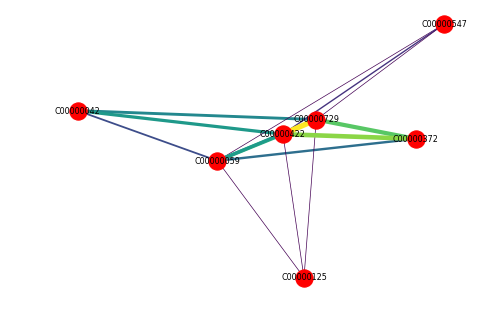

In [34]:
"""
 ratio: Bool (default=False)
    If True, edge weight is the ratio between actual shared neighbors
    and maximum possible shared neighbors (i.e., the size of the other 
    node set). If False, edges weight is the number of shared neighbors.
"""
# 二模图隶属网络——政治行动委员会
pacnet = bipartite.weighted_projected_graph(g, pacs, ratio=False)
pacnet = max(nx.connected_component_subgraphs(pacnet), key=len)      # 分析最大组元

# 用颜色和边的宽度来展示关系强度
weights = [np.log(edata['weight'] + 1) for from_, to, edata in pacnet.edges(data=True)]
nx.draw(pacnet, with_labels=True, width=weights, edge_color=weights, font_size=8)

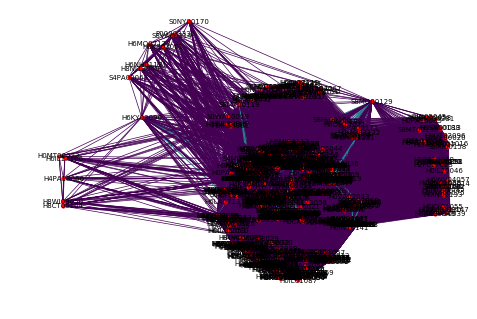

In [35]:
# 二模图隶属网络——候选人
cannet = bipartite.weighted_projected_graph(g, candidates, ratio=False)
cannet = max(nx.connected_component_subgraphs(cannet), key=len)      

# 用颜色和边的宽度来展示关系强度
weights = [np.log(edata['weight'] + 1) for from_, to, edata in cannet.edges(data=True)]
nx.draw(cannet, with_labels=True, width=weights, edge_color=weights, font_size=7, node_size=10)

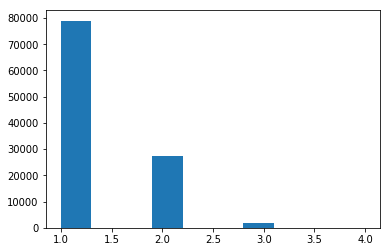

In [36]:
plt.hist(np.exp(np.array(weights)) - 1);# cannet权重分布直方图

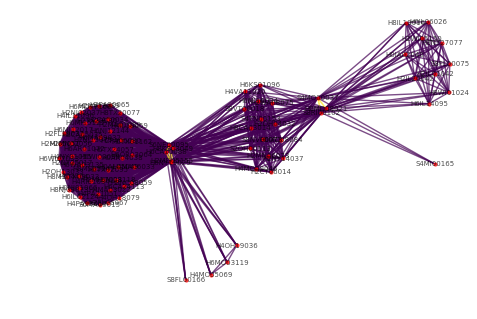

In [37]:
# 分析上图中权重最大的第三部分，设定权重阈值为2.5
cannet_trim = trim_edges(cannet, 2.5)

# 用颜色和边的宽度来展示关系强度
weights = [np.log(edata['weight'] + 1) for from_, to, edata in cannet_trim.edges(data=True)]
nx.draw(cannet_trim, with_labels=True, width=weights, edge_color=weights, font_size=7, node_size=10, alpha=0.7)